## Code implementation for Tomasi-Kanade Algorithm

Implemented by: Liyan Tan

In [ ]:
! git clone https://github.com/IshitaTakeshi/Tomasi-Kanade.git

fatal: destination path 'Tomasi-Kanade' already exists and is not an empty directory.


In [ ]:
! pip install -r Tomasi-Kanade/requirements.txt

In [ ]:
!wget -c http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
!tar xvf bunny.tar.gz

In [ ]:
!pip install pyntcloud

In [ ]:
from pyntcloud import PyntCloud

**Data description**

In [ ]:
bunny_res4 = PyntCloud.from_file("/content/bunny/data/bun270.ply")
bunny_res4.points.describe()

,x,y,z
count,236501.000000,63402.000000,31701.000000
mean,0.134851,7925.051758,0.064848
std,0.340536,10231.300781,0.023522
min,-0.062250,0.000000,-0.011259
25%,0.000000,0.098225,0.050119
50%,0.000000,0.187622,0.072846
75%,0.000000,15849.750000,0.084475
max,1.000000,31700.000000,0.094291


**Import necessary libraries.**

In [ ]:
import sys

import numpy as np

from plyfile import PlyData

from matplotlib import pyplot as plt

In [ ]:
cd /content/Tomasi-Kanade/

/content/Tomasi-Kanade


In [ ]:
from tomasi_kanade import TomasiKanade
from visualization import plot3d, plot_result
import rigid_motion

In [ ]:
def read_object(filename):
    """Read a 3D object from a PLY file"""

    ply = PlyData.read(filename)

    vertex = ply['vertex']

    x, y, z = [vertex[t] for t in ('x', 'y', 'z')]

    return np.vstack((x, y, z)).T

A PLY file, which stands for "Polygon File Format" or "Stanford Triangle Format," is a file format used to store three-dimensional data.

In [ ]:
def normalize_object_size(X):
    """
    Noramlize object size so that for
    each object point :math:`\mathbf{x} \in X`


        .. math::
            \\frac{1}{|X|} \sum_{\mathbf{x} \in X} ||\mathbf{x}|| = 1
    """
    return X / np.linalg.norm(X, axis=1).mean()

Set the camera parameters.

In [ ]:
class Camera(object):
    """
    Camera class

    Args:
        intrinsic_parameters: Intrinsic camera matrix
            :math:`K \in R^{3 \times 3}`
    """

    def __init__(self, intrinsic_parameters: np.ndarray):
        self.intrinsic_parameters = intrinsic_parameters
        self.rotation = np.eye(3)
        self.translation = np.zeros(3)

    def set_pose(self, rotation, translation):
        self.rotation = rotation
        self.translation = translation

In [ ]:
class Object3D(object):
    """
    3D object class.
    This class wraps the observation process from a view point

    Args:
        points: Points of the 3D object
    """
    def __init__(self, points: np.ndarray):
        self.X = points

    @property
    def n_points(self):
        """The number of points in the object"""
        return self.X.shape[0]

    def observed(self, camera_rotation: np.ndarray,
                 camera_translation: np.ndarray):
        """
        Return 2D points projected onto the image plane

        Args:
            camera_rotation: Rotation matrix
                which represents the camera rotation
            camera_translation: Translation vector
                which represents the camera position
        """
        R = camera_rotation
        t = camera_translation
        return rigid_motion.transform(1, R, t, self.X)

In [ ]:
def take_picture(target_object: Object3D, camera: Camera, noise_std=0.0):
    """
    Project 3D points in ``target_object`` onto the image plane defined
    by `camera`

    Args:
        target_object: Object to be seen from the ``camera``
        camera: Camera object which observes the target object
        noise_std: Standard deviation of noise added in the observation process
    """

    # Y: points seen from the camera coordinate
    Y = target_object.observed(camera.rotation, camera.translation)
    K = camera.intrinsic_parameters

    image_points = np.dot(K, Y.T).T  # project onto the image plane

    if noise_std == 0.0:
        return image_points

    noise = np.random.normal(0, noise_std, size=image_points.shape)
    return image_points + noise

In [ ]:
def to_viewpoints(M):
    x = np.array([1, 0, 0])

    def to_viewpoint(M):
        m = np.cross(M[0], M[1])
        R = np.vstack((M, m))
        return np.dot(R, x)

    F = M.shape[0] // 2
    return np.array([to_viewpoint(M_) for M_ in np.split(M, F)])


In [ ]:
np.random.seed(1234)

if len(sys.argv) < 2:
    print("Usage: $python3 run_reconstruction.py <path to PLY file>")
    exit(0)

filename = '/content/bunny/reconstruction/bun_zipper_res4.ply'

In [ ]:
# Camera intrinsic matrix
# In this case, the image coordinate is represented in a non-homogeneous 2D
# vector, therefore the intrinsic matrix is represented in a 2x3 matrix.
# In this script, we assume the orthogonal projection as a camera
# projection model
intrinsic_parameters = np.array([
    [1, 0, 0],
    [0, 1, 0]
])

# Load the 3D object from the file
X_true = read_object(filename)
X_true = normalize_object_size(X_true)

# Number of viewpoints to be used for reconstruction
n_views = 128

# Standard deviation of noise
noise_std = 0.0

target_object = Object3D(X_true)  # Create the target object
camera = Camera(intrinsic_parameters)  # Camera object to observe the target

# The ground truth object `X_true` is passed to the TomasiKanade method,
# though, this is used only for the evaluation, not reconstruction
tomasi_kanade = TomasiKanade(X_eval=X_true, learning_rate=0.0027)

epoch       iteration   main/loss   reconstruction_error
1           64          0.594559    3.27097               
2           128         0.0169032   0.00151188            
3           192         1.67827e-05  4.23429e-06           
4           256         4.93185e-08  3.35529e-09           
5           320         4.63017e-11  9.92587e-12           
6           384         2.95429e-13  4.30462e-12           
7           448         2.80627e-13  4.30462e-12           
8           512         2.78327e-13  4.22708e-12           


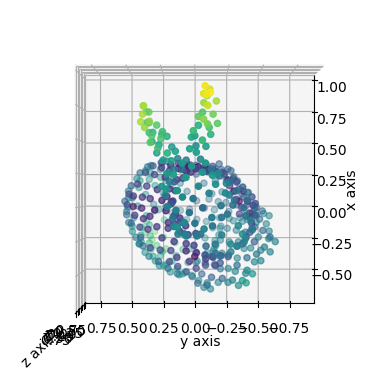

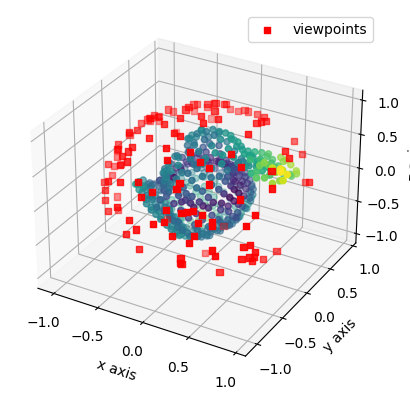

In [ ]:
for i in range(n_views):
    # Generate a random camera pose
    R = rigid_motion.random_rotation_matrix_3d()
    t = rigid_motion.random_vector_3d()
    camera.set_pose(R, t)

    # Observe the 3D object by projecting it onto the image plane
    image_points = take_picture(target_object, camera, noise_std)

    tomasi_kanade.add_image_points(image_points)

# Run reconstruction
# M is a stacked motion matrices
# X contains the reconstructed object
M, X = tomasi_kanade.run()

V = to_viewpoints(M)

plot3d(X, azim=180, elev=90)
plot_result(X, V)
plt.show()